In [ ]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
 ! pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 18.9 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824025 sha256=97a9fbf953e0642ff68ab5eac78328641f6e696a74e0e71b525ab4a844197751
  Stored in directory: /root/.cache/pip/wheels/b1/59/a0/a1a0624b5e865fd389919c1a10f53aec9b12195d6747710baf
Successfully built pyspark


In [ ]:
! pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 KB 15.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=129d6b4e10a20979075a27b6f2a35a0980b119acf779f1b923b64511dc430298
  Stored in directory: /root/.cache/pip/wheels/13/c7/b0/79f66658626032e78fc1a83103690ef6797d551cb22e56e734
Successfully built langdetect


In [ ]:
# Import SparkSession
from pyspark.sql import SparkSession
# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Check Spark Session Information
spark

In [ ]:
from pyspark.mllib import classification
from pyspark.ml.feature import RegexTokenizer
from pyspark import sql
from pyspark.sql import functions as F
import pyspark.pandas as ps
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
from langdetect import detect

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = spark.read.csv("/content/drive/MyDrive/ProjectPartB/training.1600000.processed.noemoticon.csv")

In [ ]:
dataset = dataset.toDF('target', 'id', 'date', 'flag', 'user', 'text')
dataset.show(5)

+------+----------+--------------------+--------+---------------+--------------------+
|target|        id|                date|    flag|           user|                text|
+------+----------+--------------------+--------+---------------+--------------------+
|     0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|     0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|     0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|     0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|     0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
+------+----------+--------------------+--------+---------------+--------------------+
only showing top 5 rows



In [ ]:
stats = dataset.groupby('target').count()
stats.show()

+------+------+
|target| count|
+------+------+
|     0|800000|
|     4|800000|
+------+------+



In [ ]:
cols = ['id', 'date', 'flag', 'user']
dataset = dataset.drop(*cols)
dataset.show()

+------+--------------------+
|target|                text|
+------+--------------------+
|     0|@switchfoot http:...|
|     0|is upset that he ...|
|     0|@Kenichan I dived...|
|     0|my whole body fee...|
|     0|@nationwideclass ...|
|     0|@Kwesidei not the...|
|     0|         Need a hug |
|     0|@LOLTrish hey  lo...|
|     0|@Tatiana_K nope t...|
|     0|@twittera que me ...|
|     0|spring break in p...|
|     0|I just re-pierced...|
|     0|@caregiving I cou...|
|     0|@octolinz16 It it...|
|     0|@smarrison i woul...|
|     0|@iamjazzyfizzle I...|
|     0|Hollis' death sce...|
|     0|about to file taxes |
|     0|@LettyA ahh ive a...|
|     0|@FakerPattyPattz ...|
+------+--------------------+
only showing top 20 rows



In [ ]:
# Remove usernames, links, and any special character from the tweet
dataset = dataset.withColumn("text", F.regexp_replace("text", "^@\w*", ""))
dataset = dataset.withColumn("text", F.regexp_replace("text", "(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)", ""))
dataset = dataset.withColumn("text", F.regexp_replace("text", "[$&+,:;=?@#|'<>.^*()%!-]", ""))
dataset.show()

+------+--------------------+
|target|                text|
+------+--------------------+
|     0|  thats a bummer ...|
|     0|is upset that he ...|
|     0| I dived many tim...|
|     0|my whole body fee...|
|     0| no its not behav...|
|     0| not the whole crew |
|     0|         Need a hug |
|     0| hey  long time n...|
|     0| nope they didnt ...|
|     0|      que me muera  |
|     0|spring break in p...|
|     0|I just repierced ...|
|     0| I couldnt bear t...|
|     0| It it counts idk...|
|     0| i wouldve been t...|
|     0| I wish I got to ...|
|     0|Hollis death scen...|
|     0|about to file taxes |
|     0| ahh ive always w...|
|     0| Oh dear Were you...|
+------+--------------------+
only showing top 20 rows



In [ ]:
dataset.printSchema()

root
 |-- target: string (nullable = true)
 |-- text: string (nullable = true)



In [ ]:
print((dataset.count(), len(dataset.columns)))

(1600000, 2)


In [ ]:
fig = go.Figure([go.Bar(x=['Negative', 'Positive'], 
                        y=stats['count'].to_numpy(),
                        text=stats['count'].to_numpy(),
                        textposition='auto')])
fig.update_layout(
    title='Number of samples per class',
    yaxis=dict(
        title='Number of samples'),
    xaxis=dict(
        title='Classes'))
fig.show()

/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


#### **HASHING METHOD** 

In [ ]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import NGram, VectorAssembler
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.feature import CountVectorizer

In [ ]:
# split data into train, validation and test
(train_set, val_set, test_set) = dataset.randomSplit([0.98, 0.01, 0.01], seed = 2000)

In [ ]:
tokenizer_1 = Tokenizer(inputCol="text", outputCol="words")
hash_1 = HashingTF(numFeatures=2**16, inputCol="words", outputCol='tf')
idf_1 = IDF(inputCol='tf', outputCol="features", minDocFreq=5) 
idx_1 = StringIndexer(inputCol = "target", outputCol = "label")

In [ ]:
pipeline = Pipeline(stages=[tokenizer_1, hash_1, idf_1, idx_1])

In [ ]:
pipelineFit = pipeline.fit(train_set)
train_df = pipelineFit.transform(train_set)
val_df = pipelineFit.transform(val_set)

In [ ]:
train_df.show(5)

+------+----+-----+--------------------+--------------------+-----+
|target|text|words|                  tf|            features|label|
+------+----+-----+--------------------+--------------------+-----+
|     0|    |   []|(65536,[52572],[1...|(65536,[52572],[0...|  0.0|
|     0|    |   []|(65536,[52572],[1...|(65536,[52572],[0...|  0.0|
|     0|    |   []|(65536,[52572],[1...|(65536,[52572],[0...|  0.0|
|     0|    |   []|(65536,[52572],[1...|(65536,[52572],[0...|  0.0|
|     0|    |   []|(65536,[52572],[1...|(65536,[52572],[0...|  0.0|
+------+----+-----+--------------------+--------------------+-----+
only showing top 5 rows



In [ ]:
lr = LogisticRegression(maxIter=100)
lrModel = lr.fit(train_df)
predictions = lrModel.transform(val_df)

In [ ]:
eval = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
eval.evaluate(predictions)

0.8426833874129865

In [ ]:
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(val_set.count())
accuracy

0.7731008717310087

#### **Count Vectorizer Method**

In [ ]:
%%time
tokenizer_2 = Tokenizer(inputCol="text", outputCol="words")
cv = CountVectorizer(vocabSize=2**16, inputCol="words", outputCol='cv')
idf_2 = IDF(inputCol='cv', outputCol="features", minDocFreq=5) 
idx_2 = StringIndexer(inputCol = "target", outputCol = "label")

In [ ]:
lr = LogisticRegression(maxIter=100)
pipeline = Pipeline(stages=[tokenizer_2, cv, idf_2, idx_2, lr])
pipelineFit = pipeline.fit(train_set)
predictions = pipelineFit.transform(val_set)

In [ ]:
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(val_set.count())
roc_auc = evaluator.evaluate(predictions)

In [ ]:
print ("Accuracy Score: {0:.4f}".format(accuracy))
print ("ROC-AUC: {0:.4f}".format(roc_auc))

Accuracy Score: 0.7843
ROC-AUC: 0.8528
CPU times: user 1.74 s, sys: 190 ms, total: 1.93 s
Wall time: 6min 39s


#### **N-gram Implementation** 

In [ ]:
val_set

DataFrame[target: string, text: string]

In [ ]:
def build_trigrams(inputCol=["text","target"], n=3):
    tokenizer = [Tokenizer(inputCol="text", outputCol="words")]
    ngrams = [
        NGram(n=i, inputCol="words", outputCol="{0}_grams".format(i))
        for i in range(1, n + 1)
    ]

    cv = [
        CountVectorizer(vocabSize=2**14,inputCol="{0}_grams".format(i),
            outputCol="{0}_tf".format(i))
        for i in range(1, n + 1)
    ]
    idf = [IDF(inputCol="{0}_tf".format(i), outputCol="{0}_tfidf".format(i), minDocFreq=5) for i in range(1, n + 1)]

    assembler = [VectorAssembler(
        inputCols=["{0}_tfidf".format(i) for i in range(1, n + 1)],
        outputCol="rawFeatures"
    )]
    label_stringIdx = [StringIndexer(inputCol = "target", outputCol = "label")]
    selector = [ChiSqSelector(numTopFeatures=2**14,featuresCol='rawFeatures', outputCol="features")]
    lr = [LogisticRegression(maxIter=100)]
    return Pipeline(stages=tokenizer + ngrams + cv + idf+ assembler + label_stringIdx+selector+lr)

In [ ]:
%%time
tri_pipelineFit = build_trigrams().fit(train_set)
predictions = tri_pipelineFit.transform(val_set)
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(val_set.count())
roc_auc = evaluator.evaluate(predictions)

In [ ]:
print ("Accuracy Score: {0:.4f}".format(accuracy))
print ("ROC-AUC: {0:.4f}".format(roc_auc))

Accuracy Score: 0.8003
ROC-AUC: 0.8782
CPU times: user 5.25 s, sys: 637 ms, total: 5.89 s
Wall time: 26min 46s


#### **N-gram Implementation without Chi Squared feature selection**

In [ ]:
def build_ngrams_wocs(inputCol=["text","target"], n=3):
    tokenizer = [Tokenizer(inputCol="text", outputCol="words")]
    ngrams = [
        NGram(n=i, inputCol="words", outputCol="{0}_grams".format(i))
        for i in range(1, n + 1)
    ]

    cv = [
        CountVectorizer(vocabSize=5460,inputCol="{0}_grams".format(i),
            outputCol="{0}_tf".format(i))
        for i in range(1, n + 1)
    ]
    idf = [IDF(inputCol="{0}_tf".format(i), outputCol="{0}_tfidf".format(i), minDocFreq=5) for i in range(1, n + 1)]

    assembler = [VectorAssembler(
        inputCols=["{0}_tfidf".format(i) for i in range(1, n + 1)],
        outputCol="features"
    )]
    label_stringIdx = [StringIndexer(inputCol = "target", outputCol = "label")]
    lr = [LogisticRegression(maxIter=100)]
    return Pipeline(stages=tokenizer + ngrams + cv + idf+ assembler + label_stringIdx+lr)

In [ ]:
%%time
trigram_wocs_pipelineFit = build_ngrams_wocs().fit(train_set)
predictions_wocs = trigram_wocs_pipelineFit.transform(val_set)
accuracy_wocs = predictions_wocs.filter(predictions_wocs.label == predictions_wocs.prediction).count() / float(val_set.count())
roc_auc_wocs = evaluator.evaluate(predictions_wocs)

In [ ]:
print ("Accuracy Score: {0:.4f}".format(accuracy_wocs))
print ("ROC-AUC: {0:.4f}".format(roc_auc_wocs))

Accuracy Score: 0.7960
ROC-AUC: 0.8736
CPU times: user 4.65 s, sys: 541 ms, total: 5.19 s
Wall time: 18min 14s


#### **Testing phase** 

In [ ]:
test_predictions = trigram_wocs_pipelineFit.transform(test_set)
test_accuracy = test_predictions.filter(test_predictions.label == test_predictions.prediction).count() / float(test_set.count())
test_roc_auc = evaluator.evaluate(test_predictions)

In [ ]:
print ("Accuracy Score: {0:.4f}".format(test_accuracy))
print ("ROC-AUC: {0:.4f}".format(test_roc_auc))

Accuracy Score: 0.7992
ROC-AUC: 0.8768


#### **Visualization**

In [ ]:
from os import path
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
summary = lrModel.summary
aur = summary.areaUnderROC

In [ ]:
aur

0.8744621181661617

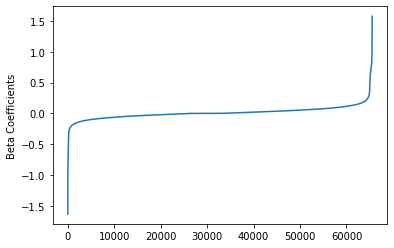

In [ ]:
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

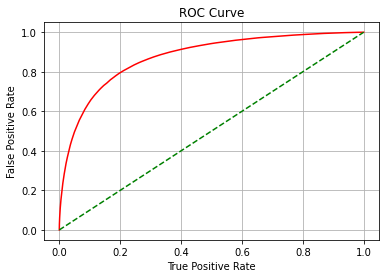

Training set areaUnderROC: 0.8744621181661617


In [ ]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'], color='red')
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid()
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

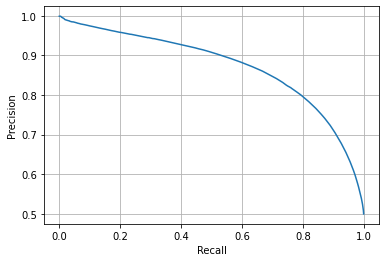

In [ ]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.grid()
plt.show()

In [ ]:
comment_words = ''
stopwords = set(STOPWORDS)

In [ ]:
dataset2

,target,text
0,0,thats a bummer You shoulda got David Carr o...
1,0,is upset that he cant update his Facebook by t...
2,0,I dived many times for the ball Managed to sa...
3,0,my whole body feels itchy and like its on fire
4,0,no its not behaving at all im mad why am i he...
...,...,...
1599995,4,Just woke up Having no school is the best feel...
1599996,4,TheWDBcom Very cool to hear old Walt intervie...
1599997,4,Are you ready for your MoJo Makeover Ask me fo...
1599998,4,Happy 38th Birthday to my boo of alll time Tup...


In [ ]:
dataset2 = dataset.toPandas()

In [ ]:
# iterate through the data 
comment_words = ''
for val in dataset2[dataset2.columns[1]][:20]:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
    # print(tokens)
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
    print(comment_words)
 


thats a bummer you shoulda got david carr of third day to do it d 
thats a bummer you shoulda got david carr of third day to do it d is upset that he cant update his facebook by texting 
thats a bummer you shoulda got david carr of third day to do it d is upset that he cant update his facebook by texting i dived many times for the ball managed to save 50 the rest go out of bounds 
thats a bummer you shoulda got david carr of third day to do it d is upset that he cant update his facebook by texting i dived many times for the ball managed to save 50 the rest go out of bounds my whole body feels itchy and like its on fire 
thats a bummer you shoulda got david carr of third day to do it d is upset that he cant update his facebook by texting i dived many times for the ball managed to save 50 the rest go out of bounds my whole body feels itchy and like its on fire no its not behaving at all im mad why am i here because i cant see you all over there 
thats a bummer you shoulda got david carr 

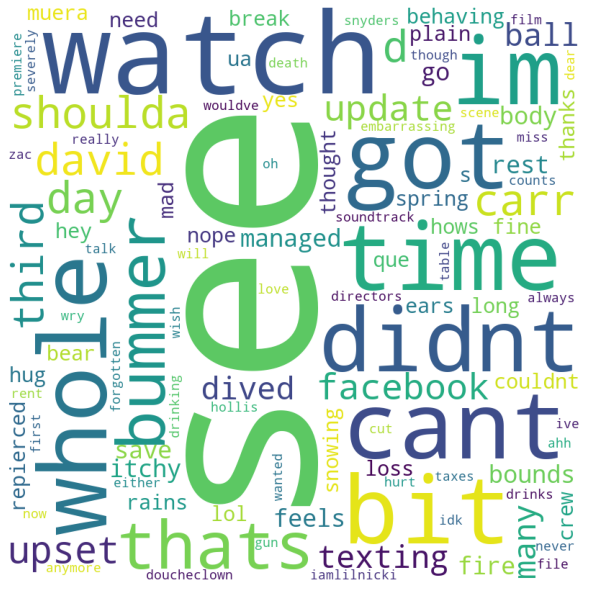

In [ ]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()
